Install libraries

In [1]:
# %pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0
# !pip install mmcv-full==1.3.9 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# !pip install openmim
# !mim install mmcv-full
# !git clone https://github.com/open-mmlab/mmpose.git
# !cd mmpose && pip install -e .

In [2]:
# !python -m pip install tensorflow-macos
# !pip install sklearn

Import Libraries

In [1]:
import json
import os
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import cv2
import random


# from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Model
import tensorflow as tf


# for modeling
import keras
from keras.callbacks import EarlyStopping

# Restart the environment after the installation and before the import
from mmpose.core.visualization import imshow_keypoints

Settings

In [2]:
DATASET_SIZE = "five_hundred"
GRAY_IMAGE = False
RESIZE_320 = True

IMAGE_RESOLUTION = "320_320" if RESIZE_320 else "640_640"
GRAY_SCALE = '1' if GRAY_IMAGE else '3'

FOLDER_PATH = '../posture_data/'+DATASET_SIZE+'/'

Prepare the data

Skeleton settings and colors

In [3]:
# Linking between the joints of the skeleton
skeleton = [[0, 1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 5], [4, 6], [5, 7], [6,8], [7, 9], 
            [4, 10], [5, 11], [10,11], [10, 12], [11, 13], [12, 14], [13, 15]]

# Palette of colors to choose from
palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                    [230, 230, 0], [255, 153, 255], [153, 204, 255],
                    [255, 102, 255], [255, 51, 255], [102, 178, 255],
                    [51, 153, 255], [255, 153, 153], [255, 102, 102],
                    [255, 51, 51], [153, 255, 153], [102, 255, 102],
                    [51, 255, 51], [0, 255, 0], [0, 0, 255],
                    [255, 0, 0], [255, 255, 255]])

# pose_kpt_color = [None] + [(127, 127, 127)] * (len(kpts[1]) - 1)
# Colors for the joints
pose_kpt_color = palette[[
            0, 0, 0, 0, 7, 7, 9, 9, 9, 9, 
            7, 7, 16, 16, 16, 16
        ]]    

# Colors for the linkings
pose_link_color = palette[[
                0, 0, 0, 0, 0, 7, 9, 9, 9, 9,
                7, 7, 7, 16, 16, 16, 16 
            ]]    

Draw lines given images, key points and the linkings between the keypoints

In [4]:
def draw_joint_line(img, kpts):
    for person in kpts:
        for joint in person:
            joint.append(1)

    # Draw the linkings between joints and return the image
    return imshow_keypoints(
        img,
        kpts,
        skeleton = skeleton,
        pose_kpt_color = pose_kpt_color,
        pose_link_color = pose_link_color,
        show_keypoint_weight=True
    )

Draw skeletons for each image

In [19]:
from alive_progress import alive_bar

full_images = []

# Loop through the annotation files
for file_label in os.listdir(FOLDER_PATH):
  # Read the file content
  with open(FOLDER_PATH + file_label) as f:
    file_annotations = json.load(f)
  print(file_label)
  
  take_half = True
  with alive_bar(int(len(file_annotations.values())), force_tty = True) as bar:
    # Loop through the images and save the data
    for image in file_annotations.values():
      # if take_half:
      ppl_joints = [list(image['person_1'].values())]
      ppl_joints.append(list(image['person_2'].values()))
      
      zeros_image = np.zeros((640, 640, 3), dtype="float32")
      skeleton_on_image = draw_joint_line(zeros_image, ppl_joints)
      if RESIZE_320:
        skeleton_on_image = cv2.resize(skeleton_on_image, (320, 320))
      if GRAY_IMAGE:
        skeleton_on_image = cv2.cvtColor(skeleton_on_image, cv2.COLOR_RGB2GRAY)
                  
      # Creates a list of images with the annotations
      full_images.append((
          skeleton_on_image, 
          int(file_label[0])
          ))  
      bar()
      
      #   take_half = False
      # else:
      #   take_half = True

1_bb.json
|██████▌⚠︎                                | (!) 81/500 [16%] in 2.7s (30.28/s)                                           


KeyboardInterrupt: 

Save the images with the poses

In [6]:
with open('../posture_data/images_skeletons/images_with_poses_{}_{}_{}.npy'.format(DATASET_SIZE, IMAGE_RESOLUTION, GRAY_SCALE), 'wb') as f:
    # np.save(f, np.array(full_images, dtype=object)) 
    np.save(f, full_images)

/Users/cristianverdecchia/miniconda3/envs/skeletoncnn/lib/python3.9/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


If you already have the data, read them

In [7]:
with open('../posture_data/images_skeletons/images_with_poses_{}_{}_{}.npy'.format(DATASET_SIZE, IMAGE_RESOLUTION, GRAY_SCALE), 'rb') as f:
    images_with_poses = np.load(f, allow_pickle = True)

Split the images for training and testing

In [8]:
np.shape(images_with_poses)

(3000, 2)

In [9]:
x = []
y = []

for image in images_with_poses:
    x.append(image[0])
    y.append(image[1])

x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

Normalize the data

In [10]:
x_train /= 255.0
x_test /= 255.0

In [11]:
len(x_train)

2850

In [12]:
if GRAY_IMAGE:
    x_train_unidimensional = x_train.reshape(-1, 320, 320, 1)
    x_test_unidimensional = x_test.reshape(-1, 320, 320, 1)

In [13]:
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1, 1))
y_train = encoder.transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

Standard ResNet18

In [14]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(16, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(16, down_sample=True)
        self.res_1_2 = ResnetBlock(16)
        self.res_2_1 = ResnetBlock(32, down_sample=True)
        self.res_2_2 = ResnetBlock(32)
        self.res_3_1 = ResnetBlock(64, down_sample=True)
        self.res_3_2 = ResnetBlock(64)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [15]:
# Disables GPU
# !python -m pip uninstall tensorflow-metal -y

In [16]:
model = ResNet18(6)
model.build(input_shape = (None, 320, 320, 3))
model.compile(optimizer = "adam",
            #   loss='categorical_crossentropy', 
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  2368      
                                                                 
 batch_normalization (BatchN  multiple                 64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

In [17]:
from keras.callbacks import EarlyStopping

STEPS = len(x_train) / 256
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")

x_to_train = []
x_to_test = []

if GRAY_IMAGE:
    x_to_train = x_train_unidimensional
    x_to_test = x_test_unidimensional
else:
    x_to_train = x_train
    x_to_test = x_test
    
history = model.fit(x_to_train, y_train, batch_size = 25, epochs=50, validation_data=(x_to_test, y_test), callbacks=[es])

Epoch 1/50


2022-08-17 13:10:20.239085: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


114/114 [==============================] - 30s 252ms/step - loss: 1.8247 - accuracy: 0.1754 - val_loss: 1.7878 - val_accuracy: 0.2267
Epoch 2/50
114/114 [==============================] - 30s 266ms/step - loss: 1.7889 - accuracy: 0.1930 - val_loss: 1.8049 - val_accuracy: 0.1667
Epoch 3/50
114/114 [==============================] - 31s 270ms/step - loss: 1.7440 - accuracy: 0.2460 - val_loss: 1.9942 - val_accuracy: 0.1933
Epoch 4/50
114/114 [==============================] - 32s 280ms/step - loss: 1.6836 - accuracy: 0.2961 - val_loss: 2.0371 - val_accuracy: 0.1867
Epoch 5/50
114/114 [==============================] - 32s 277ms/step - loss: 1.5849 - accuracy: 0.3432 - val_loss: 2.8193 - val_accuracy: 0.1533
Epoch 6/50
114/114 [==============================] - 30s 265ms/step - loss: 1.4787 - accuracy: 0.4218 - val_loss: 3.4716 - val_accuracy: 0.1800


In [18]:
model.evaluate(x_to_test, y_test)

5/5 [==============================] - 1s 67ms/step - loss: 1.7878 - accuracy: 0.2267


[1.787793755531311, 0.2266666740179062]

In [17]:
model.save("../models/cnn/{}_{}_{}".format(DATASET_SIZE, IMAGE_RESOLUTION, GRAY_SCALE))

INFO:tensorflow:Assets written to: ../models/cnn/five_hundred_640_640_1/assets


INFO:tensorflow:Assets written to: ../models/cnn/five_hundred_640_640_1/assets


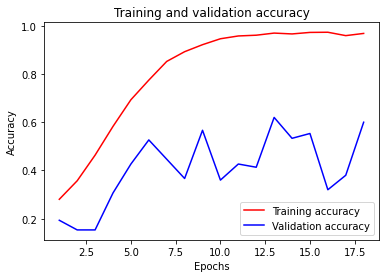

In [18]:
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(x_to_test) 
matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
print("Confusion matrix")
print(matrix)
print('')
# more detail on how well things were predicted
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

5/5 [==============================] - 1s 185ms/step
Confusion matrix
[[22  3  0  1  0  0]
 [ 1 23  0  1  2  0]
 [ 3 11  5  3  1  0]
 [ 2  3  1 21  2  0]
 [ 0 12  0  1  9  0]
 [ 2  4  0  1  3 13]]

              precision    recall  f1-score   support

           0       0.73      0.85      0.79        26
           1       0.41      0.85      0.55        27
           2       0.83      0.22      0.34        23
           3       0.75      0.72      0.74        29
           4       0.53      0.41      0.46        22
           5       1.00      0.57      0.72        23

    accuracy                           0.62       150
   macro avg       0.71      0.60      0.60       150
weighted avg       0.70      0.62      0.61       150

